# Research Challenge

```{admonition} Margaret Atwood
:class: tip
Every aspect of human technology has a dark side, including the bow and arrow
```

## 🏅 Build your own model 

You have been assigned one dataset from [MatBench](https://matbench.materialsproject.org) as introduced in the [Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-lecture9-challenge). You are free to choose and tune any machine-learning model, with any Python library, but it should be appropriate for the problem. For instance, [XGBoost](https://xgboost.readthedocs.io) could be a good starting starting point to build a regression model. You can refer back to earlier notebooks and repurpose code as needed. 

You may reach the limits of computing processing power on Google Colab. Building a useful model with limited resources is a real-world skill. Using other free resources is allowed if you find an alternative service, as is running on your own computer. A model tracker such as [wandb](https://wandb.ai) could be helpful for advanced users. If you want to try a brute force approach, a library such as [Automatminer](https://hackingmaterials.lbl.gov/automatminer) may be of interest.

This notebook should be used for keeping a record of your model development, submission, and even your presentation. You are free to edit (add/remove/delete) or rearrange the cells as you see fit.

### Your details

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Insert your values
Name = "Abhi Rajendran" # Replace with your name
CID = 1712516 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

# suppress warnings for whole notebook
import warnings
warnings.filterwarnings("ignore")

This is the work of Abhi Rajendran [CID: 1712516]


## 0 Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark. 

We are performing classification on the matbench_glass dataset. The target variable is 'gfa' which is a binary variable. 1 means glass forming and corresponds to amorphous, 0 means non full glass forming.

The top three performing models are listed in the table below,

| algorithm     | mean rocauc | std rocauc | mean f1 | mean balanced_accuracy |
|---------------|-------------|------------|---------|------------------------|
| MODNet (v0.1.12) | 0.9603      | 0.0075     | 0.9784  | 0.9603                 |
| AMMExpress v2020 | 0.8607      | 0.0199     | 0.9043  | 0.8607                 |
| RF-SCM/Magpie | 0.8587      | 0.0158     | 0.9278  | 0.8587                 |


## 1 Data preparation

Check the data distribution and apply appropriate pre-processing steps as required.

In [107]:
# Get dataset info from matminer
from matminer.datasets import get_all_dataset_info
from matminer.datasets import load_dataset

  # D (GTA - Yifan)
info = get_all_dataset_info("matbench_glass")

# Check out the info about the dataset.
print(info)

Dataset: matbench_glass
Description: Matbench v0.1 test dataset for predicting full bulk metallic glass formation ability from chemical formula. Retrieved from "Nonequilibrium Phase Diagrams of Ternary Amorphous Alloys,’ a volume of the Landolt– Börnstein collection. Deduplicated according to composition, ensuring no compositions were reported as both GFA and not GFA (i.e., all reports agreed on the classification designation). For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	gfa: Target variable. Glass forming ability: 1 means glass forming and corresponds to amorphous, 0 means non full glass forming.
Num Entries: 5680
Reference: Y. Kawazoe, T. Masumoto, A.-P. Tsai, J.-Z. Yu, T. Aihara Jr. (1997) Y. Kawazoe, J.-Z. Yu, A.-P. Tsai, T. Masumoto (ed.) SpringerMaterials
Nonequilibrium Phase Diagrams of Ternary Amorphous All

In [226]:
# Load dataset into a pandas DataFrame
df = load_dataset("matbench_glass")
raw_data = df.copy()  # Keep a copy of the raw data
print(df.shape)
df.head()

Reading file /opt/anaconda3/envs/glasses_classes/lib/python3.10/site-packages/matminer/datasets/matbench_glass.json.gz: 0it [00:00, ?it/s]0, ?it/s]

(5680, 2)


,composition,gfa
0,Al,False
1,Al(NiB)2,True
2,Al10Co21B19,True
3,Al10Co23B17,True
4,Al10Co27B13,True


In [249]:
df.info() # Check for missing data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5680 entries, 0 to 5679
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   composition  5680 non-null   object
 1   gfa          5680 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 94.3+ KB


### 1.1 Data Visualisation

First we visualise the `matbench_glass` dataset to understand how to preprocess the data. The `plot_element_fractions` function creates a plot of the fraction of compounds containing each element. We can see that Ni, Al, B and Fe are the most commonly present elements in the dataset.

This will be a binary classification problem, by viewing the distribution of classes in the `plot_gfa` function, we can see that there is a data imbalance with the amorphous class making up 4035 of 5680 (70.9%) of the dataset. This will have to be accounted for in subsequent data processing and additional weighting may be required to better represent the underweighted class.

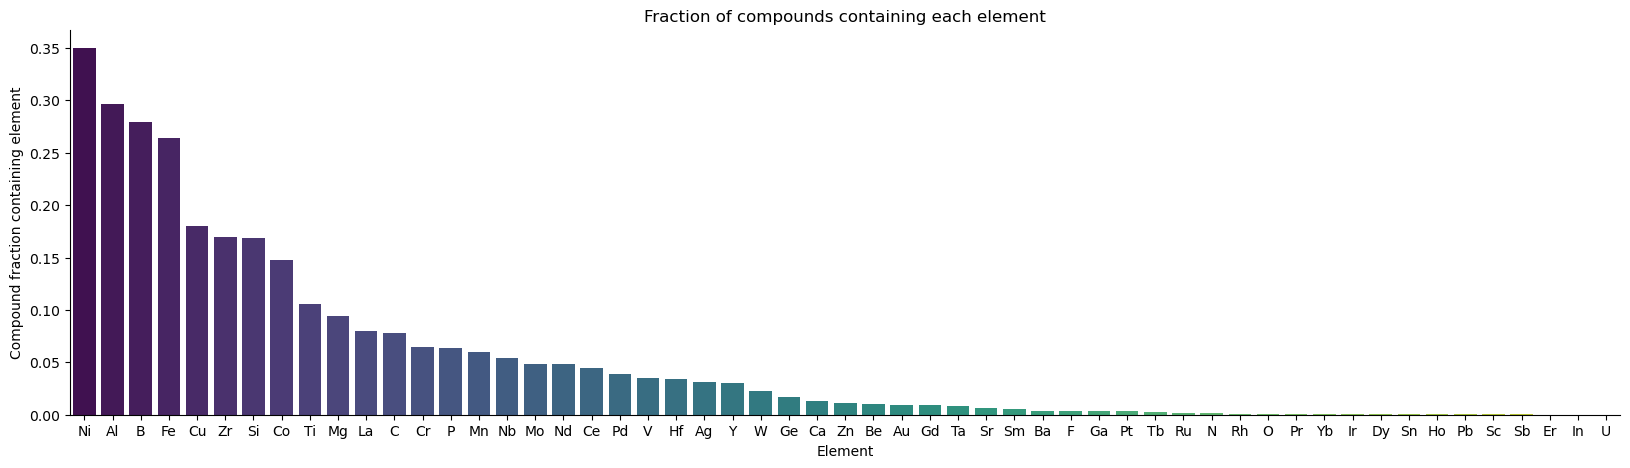

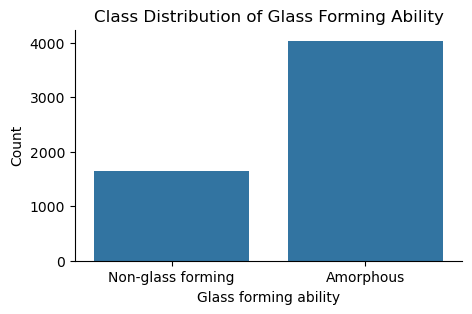

In [242]:
import matplotlib.pyplot as plt
from pymatgen.core import Composition
from collections import defaultdict


def plot_element_fractions(df): # Function to plot the fraction of compounds containing each element
    df = df.copy(deep=True)

    # Convert the 'composition' column from string to pymatgen Composition objects
    df["composition"] = df["composition"].map(Composition)

    # Apply a lambda function to 'composition' to get a dictionary of element amounts
    values = df["composition"].apply(lambda s: s.get_el_amt_dict())
    
    # Initialize dictionaries to store elements and their proportions
    elements = defaultdict(float)
    proportions = defaultdict(list)
    
    # Iterate over each composition to calculate total amounts and proportions
    for s in values:
        tot = np.sum(list(s.values())) 
        for e in s:  
            elements[e] += 1 
            proportions[e] += [s[e]/tot] 

    # Calculate the frequency of each element as a fraction of total compositions
    for elem in elements:
        elements[elem] /= len(values)

    # Calculate the mean proportion of each element
    mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
    mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True))
    elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))
    elements_df = pd.DataFrame(list(elements.items()), columns=['Element', 'Fraction'])

    # Create the plot
    plt.figure(figsize=(20,5))
    sns.barplot(x='Element', y='Fraction', data=elements_df, palette='viridis')
    sns.despine()
    plt.ylabel('Compound fraction containing element')
    plt.title('Fraction of compounds containing each element')
    plt.show()


def plot_gfa(df): 
    # Create a bar plot of the 'gfa' column to show the distribution of glass forming ability
    plt.figure(figsize=(5, 3))
    sns.countplot(x='gfa', data=df)
    plt.xlabel('Glass forming ability')
    plt.xticks([0, 1], ['Non-glass forming', 'Amorphous'])
    plt.ylabel('Count')
    plt.title('Class Distribution of Glass Forming Ability')
    sns.despine()
    plt.show()

plot_element_fractions(raw_data)
plot_gfa(raw_data)


### 1.2 Data Featurisation

Having verified there are no missing values, we now need to featurise the data as our models cannot accept raw composition as an input.

The first way we do this is using one-hot encoding and taking the `stats=["mean"]` of the element count. This is taken care of in the `featurise_composition` method of the `DataProcessor` class.

The second way this is done is by featurising the composition column using Pymatgen, this adds a richer representation from real world data which is tied to the composition of the compound. Later in the analysis we find the most important properties are covalent radius and electronegativity. This is done in the `featurise_with_pymatgen` method.

In both cases we scale the values using the sklearn MinMaxScaler and then compare the classification accuracy on both. This is done in the `scale_data` method.

In [259]:
from matminer.featurizers.composition.composite import ElementProperty
from pymatgen.core import Composition
from sklearn.preprocessing import MinMaxScaler
from elementembeddings.composition import composition_featuriser

class DataProcessor:
    """
    A class that provides methods for data processing and featurisation.

    Args:
        embedding (str): The embedding to be used for composition featurisation.

    Attributes:
        embedding (str): The embedding used for composition featurisation.
        featuriser (ElementProperty): The featuriser object for element properties.

    Methods:
        featurise_composition: Featurises the composition column using one-hot encoding.
        featurise_with_pymatgen: Featurises the composition column using pymatgen.
        scale_data: Scales the numerical columns in the dataframe.

    """

    def __init__(self, embedding):
        self.embedding = embedding
        self.featuriser = ElementProperty.from_preset(preset_name='magpie')
        self.featuriser.set_n_jobs(1)
    
    def featurise_composition(self, df):
        """
        Featurises the composition column of the dataframe using one-hot encoding.

        Args:
            df (pandas.DataFrame): The input dataframe.

        Returns:
            pandas.DataFrame: The featurised dataframe.

        """
    
        df = df.copy(deep=True)

        print(f"Using {self.embedding} embedding for composition featurisation.")
        
        onehot_df = composition_featuriser(df["composition"], embedding=self.embedding, stats=["sum"])
        onehot_df.drop(columns=['formula'], inplace=True)  # Drop the original composition column

        #add gfa column to the onehot_df
        onehot_df['gfa'] = df['gfa'].astype(int)
        
        return onehot_df
    
    def featurise_with_pymatgen(self, df, col_id='composition'):
        """
        Featurises the composition column of the dataframe using pymatgen.

        Args:
            df (pandas.DataFrame): The input dataframe.
            col_id (str): The name of the composition column.

        Returns: 
            pandas.DataFrame: The featurised dataframe.

        """

        df = df.copy(deep=True)
        print(f"Featurising the composition column using pymatgen.")

        df["composition_pmg"] = df[col_id].map(Composition)
        df_pmg = self.featuriser.featurize_dataframe(df, col_id='composition_pmg')

        return df_pmg
    
    def scale_data(self, df):
        """
        Scale the numerical columns in the given DataFrame.

        Parameters:
        - df (pandas.DataFrame): The DataFrame containing the data to be scaled.

        Returns:
        - df (pandas.DataFrame): The DataFrame with the scaled numerical columns.
        """

        df = df.copy(deep=True)
        print("Scaling the numerical columns.")

        # Get the numerical columns to scale
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

        # Scale the data
        scaler = MinMaxScaler()
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

        return df

#### 1.2.1 One Hot Encoded Data

In [260]:
data_processor = DataProcessor(embedding="atomic") #can be changed to atomic or magpie
one_hot_data = data_processor.featurise_composition(raw_data)
one_hot_scaled_data = data_processor.scale_data(one_hot_data)

one_hot_scaled_data

Using atomic embedding for composition featurisation.
Featurising compositions...


  0%|          | 0/5680 [00:00<?, ?it/s]

100%|██████████| 5680/5680 [00:05<00:00, 1075.14it/s]


Computing feature vectors...


100%|██████████| 5680/5680 [00:00<00:00, 212415.27it/s]


Scaling the numerical columns.


,sum_H,sum_He,sum_Li,sum_Be,sum_B,sum_C,sum_N,sum_O,sum_F,sum_Ne,...,sum_Ds,sum_Rg,sum_Cn,sum_Nh,sum_Fl,sum_Mc,sum_Lv,sum_Ts,sum_Og,gfa
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.024540,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.233129,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.208589,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.159509,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5675,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5676,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5677,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5678,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### 1.2.2 Pymatgen Featurised Data

In [261]:
data_processor = DataProcessor(embedding="magpie") #can be changed to atomic or magpie
featurised_data = data_processor.featurise_with_pymatgen(raw_data)
scaled_data = data_processor.scale_data(featurised_data)
processed_data = scaled_data.copy()

processed_data

Featurising the composition column using pymatgen.


ElementProperty: 100%|██████████| 5680/5680 [00:11<00:00, 484.20it/s]


Scaling the numerical columns.


,composition,gfa,composition_pmg,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Al,False,(Al),0.150000,0.0125,0.000000,0.072975,0.000000,0.120000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.991111,0.885714,0.000000,0.960342,0.000000,0.936508
1,Al(NiB)2,True,"(Al, Ni, B)",0.016667,0.2000,0.294872,0.115235,0.299240,0.013333,0.818182,...,0.282089,0.118423,0.270805,0.000000,0.728889,0.885714,0.259912,0.707386,0.275832,0.000000
2,Al10Co21B19,True,"(Al, Co, B)",0.016667,0.1875,0.282051,0.115839,0.287417,0.306667,0.772727,...,0.733642,0.323387,0.714861,0.733642,0.728889,0.885714,0.259912,0.580480,0.174397,0.444444
3,Al10Co23B17,True,"(Al, Co, B)",0.016667,0.1875,0.282051,0.129120,0.289968,0.306667,0.772727,...,0.733642,0.354186,0.728947,0.733642,0.728889,0.885714,0.259912,0.592484,0.163458,0.444444
4,Al10Co27B13,True,"(Al, Co, B)",0.016667,0.1875,0.282051,0.155684,0.282119,0.306667,0.772727,...,0.733642,0.415783,0.728947,0.733642,0.728889,0.885714,0.259912,0.616494,0.136342,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5675,ZrTi9,False,"(Zr, Ti)",0.300000,0.3500,0.230769,0.235979,0.099338,0.240000,0.545455,...,0.000011,0.000010,0.000004,0.000011,0.853333,0.000000,0.000000,0.628069,0.000000,0.444444
5676,ZrTiSi2,True,"(Zr, Ti, Si)",0.166667,0.3500,0.333333,0.216358,0.268273,0.133333,0.545455,...,0.000011,0.000003,0.000008,0.000000,0.853333,0.942857,0.145374,0.804924,0.160707,0.968254
5677,ZrTiSi3,True,"(Zr, Ti, Si)",0.166667,0.3500,0.333333,0.190700,0.250184,0.133333,0.545455,...,0.000011,0.000002,0.000007,0.000000,0.853333,0.942857,0.145374,0.840295,0.154279,0.968254
5678,ZrVCo8,True,"(Zr, V, Co)",0.316667,0.3500,0.217949,0.297860,0.074197,0.306667,0.560606,...,0.733642,0.615975,0.469531,0.733642,0.853333,1.000000,0.154185,0.665584,0.061361,0.444444


## 2 Model choice 

Here we select the model to use for our subsequent analysis. 

We do this by comparing 9 classifiers and to ensure generalisability on the dataset we perform cross validation with 5 folds. The performance of these models is tested on each of the one-hot encoded and pymatgen featurised dataset.

In addition to this, to ensure that the imbalanced dataset + the ordering of data within the dataset has no effect, we use a `StratifiedShuffleSplit` ensuring that relative class frequencies are approximately preserved in each train and test set.


In [228]:
# Model Selection and Evaluation
from sklearn.model_selection import cross_validate  # Cross-validation
from sklearn.model_selection import StratifiedShuffleSplit  # ShuffleSplit CV

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, SGDClassifier  # Linear models for classification
from sklearn.svm import SVC  # C-Support Vector Classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble methods
from sklearn.neighbors import KNeighborsClassifier  # Classifier implementing the k-nearest neighbors vote
from sklearn.tree import DecisionTreeClassifier  # Decision Tree Classifier
from sklearn.neural_network import MLPClassifier  # Multi-layer Perceptron classifier
from xgboost import XGBClassifier  # Gradient Boosting for classification from XGBoost library

models = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    XGBClassifier(),
    SGDClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(),  # Neural network classifier
]

# scoring metric list
scoring_list = ["accuracy", "roc_auc", "f1"]

# create a function to perform cross validation
def cross_validate_models(models, X, y, cv=5):
    results = []
    for model in models:
        kfold = StratifiedShuffleSplit(n_splits=cv, random_state=42)
        scores = cross_validate(model, X, y, cv=kfold, scoring=scoring_list)
        results.append({"model": model.__class__.__name__,
                        "mean_accuracy": np.mean(scores['test_accuracy']),
                        "std_accuracy": np.std(scores['test_accuracy']),
                        "mean_roc_auc": np.mean(scores['test_roc_auc']),
                        "std_roc_auc": np.std(scores['test_roc_auc']),
                        "mean_f1": np.mean(scores['test_f1']),
                        "std_f1": np.std(scores['test_f1'])})

    return pd.DataFrame(results)

### 2.1 One-hot encoded dataset model scores

In [262]:
X_one_hot = one_hot_scaled_data.drop(columns=["gfa"])
y_one_hot = one_hot_scaled_data["gfa"]

# cross validate the models using one-hot encoded composition
print("Cross validating models using one-hot encoded composition")
cross_val_results = cross_validate_models(models, X_one_hot, y_one_hot)

cross_val_results = cross_val_results.round(3)
cross_val_results.sort_values(by="mean_roc_auc", ascending=False)

Cross validating models using one-hot encoded composition


,model,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc,mean_f1,std_f1
2,RandomForestClassifier,0.868,0.013,0.928,0.006,0.909,0.008
5,XGBClassifier,0.845,0.010,0.905,0.005,0.894,0.006
3,KNeighborsClassifier,0.832,0.013,0.880,0.008,0.885,0.009
8,MLPClassifier,0.830,0.014,0.880,0.009,0.884,0.010
7,GradientBoostingClassifier,0.800,0.013,0.847,0.008,0.869,0.008
1,SVC,0.762,0.012,0.825,0.006,0.851,0.007
4,DecisionTreeClassifier,0.842,0.017,0.806,0.022,0.889,0.012
6,SGDClassifier,0.717,0.009,0.770,0.019,0.830,0.005
0,LogisticRegression,0.718,0.004,0.753,0.023,0.828,0.003


### 2.2 Pymatgen featurised dataset model scores

In [133]:
combined_data = processed_data.drop(columns=["composition", "composition_pmg"])
X = combined_data.drop(columns=["gfa"])
y = combined_data["gfa"]

# cross validate the models using features from pymatgen
print("Cross validating models using features from pymatgen")
cross_val_results = cross_validate_models(models, X, y)

cross_val_results = cross_val_results.round(3)
cross_val_results.sort_values(by="mean_roc_auc", ascending=False)

Cross validating models using features from pymatgen


,model,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc,mean_f1,std_f1
2,RandomForestClassifier,0.894,0.012,0.954,0.005,0.927,0.009
5,XGBClassifier,0.891,0.009,0.954,0.006,0.925,0.007
7,GradientBoostingClassifier,0.858,0.011,0.911,0.004,0.904,0.007
8,MLPClassifier,0.849,0.009,0.910,0.010,0.896,0.007
3,KNeighborsClassifier,0.854,0.009,0.909,0.008,0.901,0.006
1,SVC,0.817,0.009,0.866,0.007,0.878,0.006
4,DecisionTreeClassifier,0.863,0.012,0.832,0.011,0.904,0.009
0,LogisticRegression,0.800,0.006,0.829,0.008,0.867,0.004
6,SGDClassifier,0.788,0.009,0.828,0.006,0.859,0.008


<Figure size 1000x500 with 0 Axes>

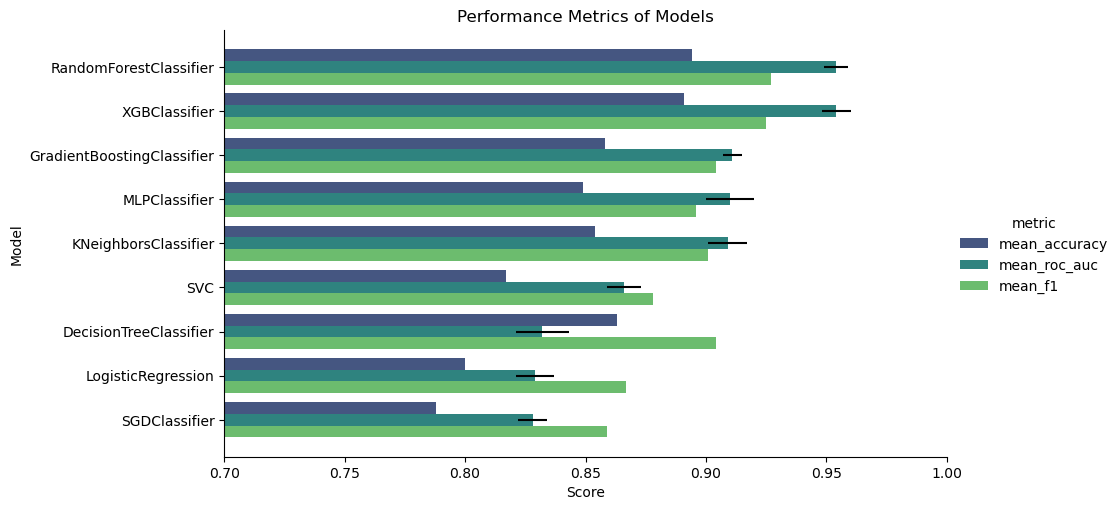

In [222]:
#create catplot bar chart for mean_accuracy, mean_roc_auc and mean_f1 and plot descending order of mean_roc_auc
error_vars = ["std_accuracy", "std_roc_auc", "std_f1"]
sorted_models = cross_val_results.sort_values(by='mean_roc_auc', ascending=False)
melted = sorted_models.melt(id_vars="model", value_vars=["mean_accuracy", "mean_roc_auc", "mean_f1"], var_name="metric", value_name="score")
# standard deviation is stored in std_accuracy, std_roc_auc, std_f1, add error bars to the plot
plt.figure(figsize=(10, 5))
sns.catplot(data=melted, x="score", y="model", hue="metric", kind="bar", height=5, aspect=2, palette="viridis")
plt.errorbar(x=sorted_models["mean_roc_auc"], y=sorted_models["model"], xerr=sorted_models["std_roc_auc"], fmt='none', ecolor='k')
plt.xlim(0.7, 1)
plt.xlabel("Score")
plt.ylabel("Model")
plt.title("Performance Metrics of Models")
plt.show()

### 2.1 A note on final model choice

The Pymatgen featurised dataset performs better than the one-hot encoded dataset when classified in the same way. In both cases the `RandomForestClassifier` was found to have the highest roc_auc score. 

In subsequent training it was decided to use the Pymatgen featurised dataset along with the `RandomForestClassifier`, as is consistent previous models with high scores, one-hot encoding is not sufficent to score highly on the MatBench Leaderboard.

In further testing a neural network classifier is also considered and we believe that this richer data representation can be used to train a better classifier.

## 3 Training and testing

Train, validate and test your model. Comment on the performance metrics. Note the best-performing model on the [MatBench](https://matbench.materialsproject.org) leaderboard.  With limited resources, don't expect to match this performance, but you should do better than a baseline model. 

The top three performing models are listed in the table below,

| algorithm     | mean rocauc | std rocauc | mean f1 | mean balanced_accuracy |
|---------------|-------------|------------|---------|------------------------|
| MODNet (v0.1.12) | 0.9603      | 0.0075     | 0.9784  | 0.9603                 |
| AMMExpress v2020 | 0.8607      | 0.0199     | 0.9043  | 0.8607                 |
| RF-SCM/Magpie | 0.8587      | 0.0158     | 0.9278  | 0.8587                 |

### 3.1 Model Optimizer Class

The `ModelOptimizer` class is a utility for hyperparameter tuning and model evaluation. It uses `GridSearchCV` to find the best hyperparameters for a given classifier and a parameter grid. The class also provides methods to fit the model, evaluate its performance on a test set (including ROC AUC score, classification report, and confusion matrix), and retrieve the best parameters found by the grid search.

In [265]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

class ModelOptimizer:
    def __init__(self, classifier, param_grid, cv=5, scoring='roc_auc'):
        """
        Initializes the ModelOptimizer with a classifier, parameter grid, and other settings for GridSearchCV.
        
        Parameters:
        - classifier: The machine learning classifier to optimize.
        - param_grid: The hyperparameter grid to search over.
        - cv: The number of cross-validation folds.
        - scoring: The scoring method to use.
        - n_jobs: The number of jobs to run in parallel.
        - verbose: The verbosity level.
        """
        self.classifier = classifier
        self.param_grid = param_grid
        self.cv = cv
        self.scoring = scoring
        self.grid_search = None
        self.best_params = None
        self.best_model = None

    def fit(self, X_train, y_train):
        """
        Fits the GridSearchCV to find the best hyperparameters and retrains the classifier on the entire training set.
        
        Parameters:
        - X_train: Training features.
        - y_train: Training labels.
        """
        warnings.filterwarnings("ignore")
        kfold = StratifiedShuffleSplit(n_splits=self.cv, random_state=42)

        grid_search = GridSearchCV(estimator=self.classifier, param_grid=self.param_grid,
                                        cv=kfold, n_jobs=-1, verbose=1,
                                        scoring=self.scoring)
        
        grid_search.fit(X_train, y_train)

        self.best_params = grid_search.best_params_
        self.best_model = grid_search.best_estimator_

    def evaluate(self, X_test, y_test):
        """
        Evaluates the best model on the test set and prints out various metrics.
        
        Parameters:
        - X_test: Test features.
        - y_test: Test labels.
        """
        y_pred = self.best_model.predict(X_test)

        #roc_auc
        roc_auc = roc_auc_score(y_test, y_pred)
        print(f"\nROC AUC: {roc_auc:.4f}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=["Non-full glass", "Amorphous"]))     
        
        # Plot confusion matrix
        #1 means glass forming and corresponds to amorphous, 0 means non full glass forming.
        
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=["Non-full glass", "Amorphous"]).plot(values_format='d', cmap='Blues')
        plt.show()

    def get_best_params(self):
        """
        Returns the best parameters found by GridSearchCV.
        """
        return self.best_params


### 3.2 Running the model optimizer

Here we specify the `param_grid` over which we will grid search for the optimal parameters. We get ROC AUC: 0.8091 which is lower than the one we found from our earlier cross validation though this is as a result of the random state and the exact split of data we have.

The best parameters are `{'bootstrap': False, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}`. The overall `param_grid` has been shrunk and a scaled down version is shown in the cell below to ensure quick running of the code.

We can see that there is a poor *recall* value on the Non-full glass class of 0.65. This can be attributed to the class imbalance leading to the model overpredicting the number of compounds that are classed as amorphous.

Fitting 5 folds for each of 6 candidates, totalling 30 fits

ROC AUC: 0.8073

Classification Report:
                precision    recall  f1-score   support

Non-full glass       0.88      0.65      0.75       329
     Amorphous       0.87      0.96      0.92       807

      accuracy                           0.87      1136
     macro avg       0.88      0.81      0.83      1136
  weighted avg       0.87      0.87      0.87      1136



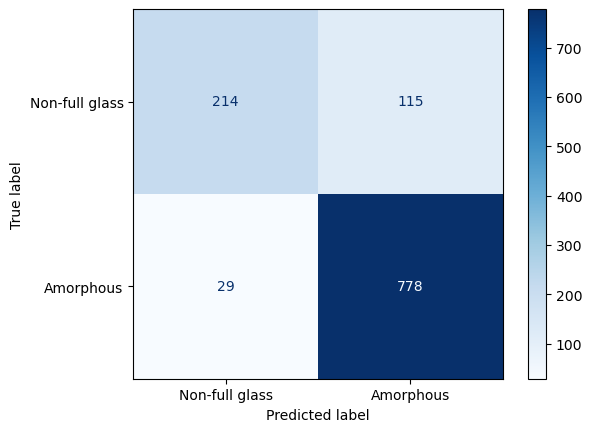

The best parameters are {'bootstrap': False, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [266]:
warnings.filterwarnings("ignore") 

classifier = RandomForestClassifier()

param_grid = {
    'n_estimators': [300, 400, 500], 
    'max_depth': [9],  
    'min_samples_split': [2], 
    'min_samples_leaf': [1], 
    'bootstrap': [True, False]  
}

#split with balanced classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize, fit, and evaluate the model optimizer
model_optimizer = ModelOptimizer(classifier, param_grid)
model_optimizer.fit(X_train, y_train)
model_optimizer.evaluate(X_test, y_test)
print(f"The best parameters are {model_optimizer.get_best_params()}")


### 3.3 Using SMOTE to better represent the minority class

SMOTE, or Synthetic Minority Over-sampling Technique, can improve the performance of a classifier by addressing class imbalance, which is a common problem in machine learning. By generating synthetic examples in the feature space, SMOTE can help to balance the classes in the training data, leading to improved classifier performance by enabling the model to learn more robust decision boundaries.

We see the improved ROC AUC of 0.8854 and a far better recall score on the Non-full glass.

The drawback is Over-generalization: Since SMOTE operates in the feature space, it can create synthetic examples in regions of the feature space where the minority class is not represented.



Fitting 5 folds for each of 6 candidates, totalling 30 fits

ROC AUC: 0.8854

Classification Report:
                precision    recall  f1-score   support

Non-full glass       0.89      0.88      0.88       807
     Amorphous       0.88      0.89      0.89       807

      accuracy                           0.89      1614
     macro avg       0.89      0.89      0.89      1614
  weighted avg       0.89      0.89      0.89      1614



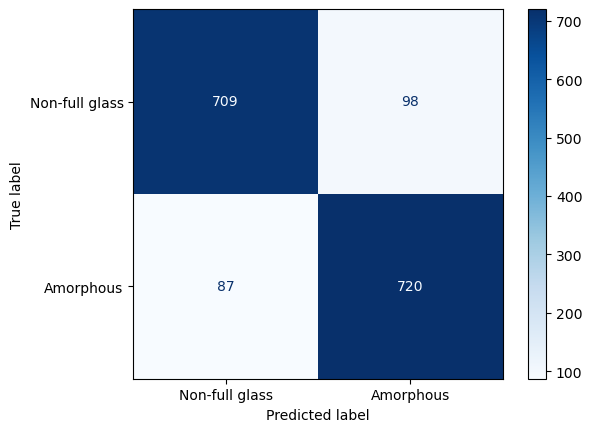

The best parameters are {'bootstrap': False, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [271]:
from imblearn.over_sampling import SMOTE

classifier = RandomForestClassifier()

#Use SMOTE to oversample the minority class
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)

# Initialize, fit, and evaluate the model optimizer
model_optimizer = ModelOptimizer(classifier, param_grid)
model_optimizer.fit(over_X_train, over_y_train)
model_optimizer.evaluate(over_X_test, over_y_test)
print(f"The best parameters are {model_optimizer.get_best_params()}")

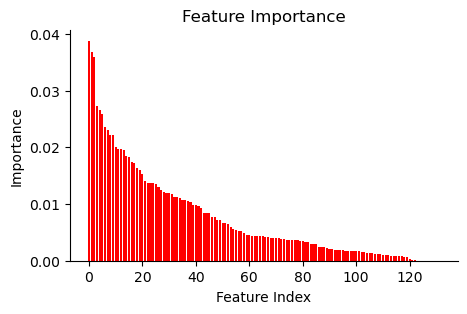

In [256]:
importances = model_optimizer.best_model.feature_importances_

# Get the indices that would sort the importances array from largest to smallest
indices = np.argsort(importances)[::-1]

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Create a bar plot of the feature importance
ax.bar(range(X.shape[1]), importances[indices], color="r", align="center")

# Set the labels
sns.despine()
ax.set_xlabel("Feature Index")
ax.set_title("Feature Importance")
ax.set_ylabel("Importance")

plt.show()


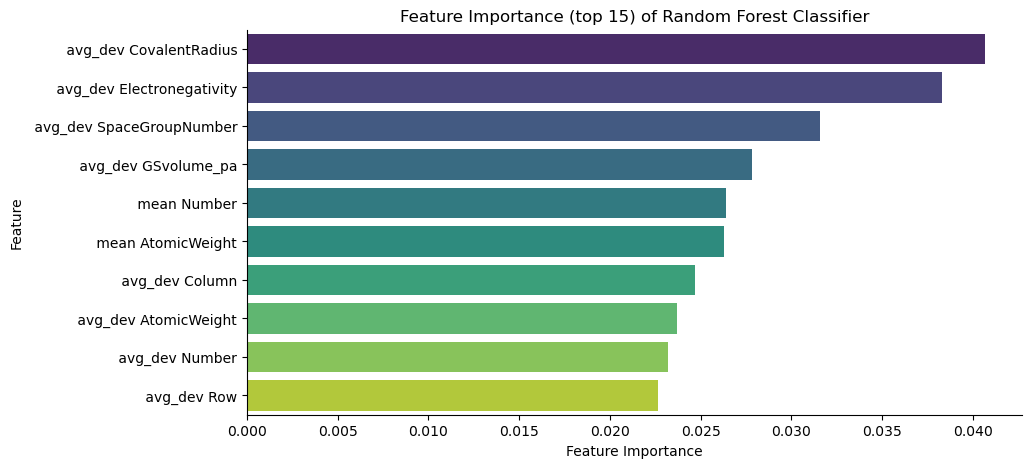

In [220]:
# match column name to feature index
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

#remove MagpieData from the feature names
feature_importance['feature'] = feature_importance['feature'].str.replace('MagpieData', '')

# Create a bar plot of the top 10 most important features
plt.figure(figsize=(10, 5))
#plt.bar(feature_importance['feature'][:30], feature_importance['importance'][:30], color='b')
sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
sns.despine()
plt.title("Feature Importance (top 15) of Random Forest Classifier")
plt.show()

Using MPS device
Input dimension: 132
Epoch 1/30, Training Loss: 0.5481277683251341, Validation Loss: 0.4536203162537681
Epoch 2/30, Training Loss: 0.4853255727761228, Validation Loss: 0.4282616178194682
Epoch 3/30, Training Loss: 0.46601646718844564, Validation Loss: 0.41438838508394027
Epoch 4/30, Training Loss: 0.4382013426700109, Validation Loss: 0.39885233839352924
Epoch 5/30, Training Loss: 0.4329909850174273, Validation Loss: 0.4042801592085097
Epoch 6/30, Training Loss: 0.4302423428481733, Validation Loss: 0.40352461404270595
Epoch 7/30, Training Loss: 0.4252830831937387, Validation Loss: 0.4070619245370229
Epoch 8/30, Training Loss: 0.41404981974145055, Validation Loss: 0.41385484900739455
Epoch 9/30, Training Loss: 0.41245018302554814, Validation Loss: 0.37088702701860005
Epoch 10/30, Training Loss: 0.4080082639841966, Validation Loss: 0.3715125603808297
Epoch 11/30, Training Loss: 0.39851634855001744, Validation Loss: 0.37597817016972435
Epoch 12/30, Training Loss: 0.4038095

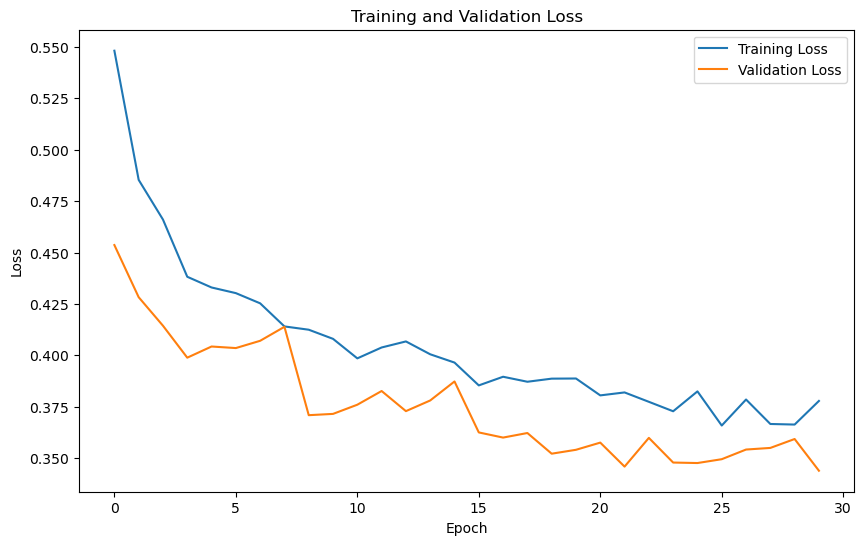

Accuracy: 0.8380281690140845
ROC AUC: 0.7815768560053936
                precision    recall  f1-score   support

Non-full glass       0.76      0.65      0.70       329
     Amorphous       0.86      0.92      0.89       807

      accuracy                           0.84      1136
     macro avg       0.81      0.78      0.79      1136
  weighted avg       0.83      0.84      0.83      1136



In [254]:
# pytorch neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set the batch size
batch_size = 64

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    

# Check if MPS is available
if torch.backends.mps.is_available():
    # Set the device to MPS
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")


# Create a neural network class for binary classification

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Increase the number of neurons
        self.bn1 = nn.BatchNorm1d(64)  # Adjust to match the number of neurons
        self.dropout1 = nn.Dropout(0.3)  # Increase the dropout rate
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)  # Add a new layer
        self.dropout3 = nn.Dropout(0.3)  # Add a new layer
        self.fc4 = nn.Linear(16, 1)  # Add a new layer
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))  # Add a new layer
        x = self.dropout3(x)  # Add a new layer
        x = torch.sigmoid(self.fc4(x))  # Adjust to use the new layer
        return x
        
    
# Create an instance of the neural network
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")
model = NeuralNetwork(input_dim)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
#learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min')

# Train the model
# Send the model to the device
model.to(device)

# Train the model
n_epochs = 30

training_losses = []
validation_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    average_training_loss = running_loss / len(train_loader)
    training_losses.append(average_training_loss)
    
    # Evaluate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(test_loader)}")

    scheduler.step(val_loss) # Adjust the learning rate

    average_validation_loss = val_loss / len(test_loader)
    validation_losses.append(average_validation_loss)

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluate the model
model.eval()
y_pred = model(X_test_tensor.to(device)).detach().cpu().numpy()

# Convert the predictions to binary
y_pred = (y_pred > 0.5).astype(int)


# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc}")



# Save the model
torch.save(model.state_dict(), "model.pth")

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["Non-full glass", "Amorphous"]))


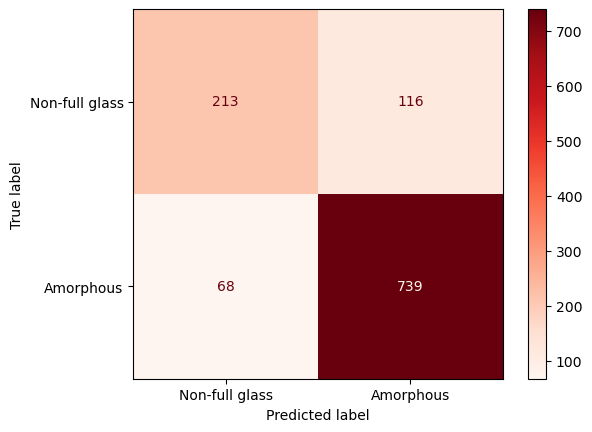

In [255]:
# create confusion matrix for neural network
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-full glass", "Amorphous"]).plot(values_format='d', cmap='Reds')

## Large Language Model (LLM) usage declaration

You should acknowledge any use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-3, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

In [125]:
# Spare cell




## ☘️ Final word

Good luck building your own model! I hope that you enjoyed the course and exercises. Dive deeper into the aspects that caught your interest. A useful starting point may be the [Resources](https://aronwalsh.github.io/MLforMaterials/Resources.html) page. 

Remember that submission is on Blackboard and this time you should upload the actual Juypter Notebook (`.ipynb` file), as well as your recorded narrated presentation (maximum 5 minutes; see guides on using [Zoom](https://www.youtube.com/watch?v=H9qhoAIzW3E) or [Powerpoint](https://www.youtube.com/watch?v=Y5dgwwa5XRA) for this purpose).